# Import

In [83]:
import glob
import json
from typing import List, Tuple

import geobleu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import polars as pl
import seaborn as sns

# Function

In [84]:
def read_submit_json(output_dir: str) -> dict:
    """予測後のファイルを読み込み

    Args:
        output_dir (str): 格納先のファイルのdirを指定

    Returns:
        dict: [generate]予測値 [referense]正解値
    """

    submit_file = glob.glob(output_dir)[0]

    with open(submit_file, "r") as f:
        subs = json.load(f)

    return subs

In [85]:
def caluc_test_score(subs: dict) -> Tuple[List, List]:
    """評価用データに関する精度結果を表示

    Args:
        subs (dict): 提出用subs

    Returns:
        list: 各uidごとのgeobleuの値
        list: 各uidごとのdtwの値
    """

    list_geobleu_val = []
    list_dtw_val = []
    cnt = 0

    for i in range(2000):

        generated = subs["generated"][i]
        reference = subs["reference"][i]

        if len(generated) > 0:
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            list_geobleu_val.append(geobleu_val)

            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            list_dtw_val.append(dtw_val)

        else:
            cnt += 1

    print(f"計算できなかったuid数は {cnt}件")
    print("geobleu: {}".format(np.mean(list_geobleu_val)))
    print("dtw: {}".format(np.mean(list_dtw_val)))

    return list_geobleu_val, list_dtw_val

# CalucTestScore
- 2000uid * 15dの範囲にてgeoblueとdtwを算出
- uid単位で評価したうえで平均値を最終評価とする

In [86]:
# 評価対象のファイル

base_path = "/kaggle/s3storage/01_public/humob-challenge-2024/output/test"
run_name = "percentile95"
file_name = "batchsize128_epochs50_embedsize128_layersnum4_headsnum8_cuda0_lr2e-05_seed0"

## Dataset B

In [87]:
output_dir = f"{base_path}/{run_name}/taskB/{file_name}/*json"
subsB = read_submit_json(output_dir)

list_geobleu_val, list_dtw_val = caluc_test_score(subsB)

計算できなかったuid数は 0件
geobleu: 0.11005220397512917
dtw: 66.20717135047957


## Dataset C

## Dataset D

# Analysys

In [21]:
output_dir = (
    f"{base_path}/{run_name}/taskB/batchsize128_epochs1_embedsize128_layersnum4_headsnum8_cuda0_lr2e-05_seed0/*json"
)
subsB = read_submit_json(output_dir)

list_geobleu_val_ep_1, list_dtw_val_ep_1 = caluc_test_score(subsB)

計算できなかったuid数は 0件
geobleu: 0.0017551713970495606
dtw: 385.0024172985215


In [26]:
output_dir = (
    f"{base_path}/{run_name}/taskB/batchsize128_epochs10_embedsize128_layersnum4_headsnum8_cuda0_lr2e-05_seed0/*json"
)
subsB = read_submit_json(output_dir)

list_geobleu_val_ep_10, list_dtw_val_ep_10 = caluc_test_score(subsB)

計算できなかったuid数は 0件
geobleu: 0.020381211173639613
dtw: 224.86270387242917


In [22]:
# リストにカテゴリを付ける
data = [list_geobleu_val, list_geobleu_val_ep_10, list_geobleu_val_ep_1]

# boxplotの表示
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.xticks([0, 1, 2], ["epoch 50", "epoch 10", "epoch 1"])  # x軸にカテゴリラベルを設定
plt.title("Comparison of geobleu Score")
plt.ylabel("Scores")
plt.show()

NameError: name 'list_geobleu_val_ep_10' is not defined

In [23]:
# リストにカテゴリを付ける
data = [list_dtw_val, list_dtw_val_ep_10, list_dtw_val_ep_1]

# boxplotの表示
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.xticks([0, 1, 2], ["epoch 50", "epoch 10", "epoch 1"])  # x軸にカテゴリラベルを設定
plt.title("Comparison of dtw Score")
plt.ylabel("Scores")
plt.show()

NameError: name 'list_dtw_val_ep_10' is not defined

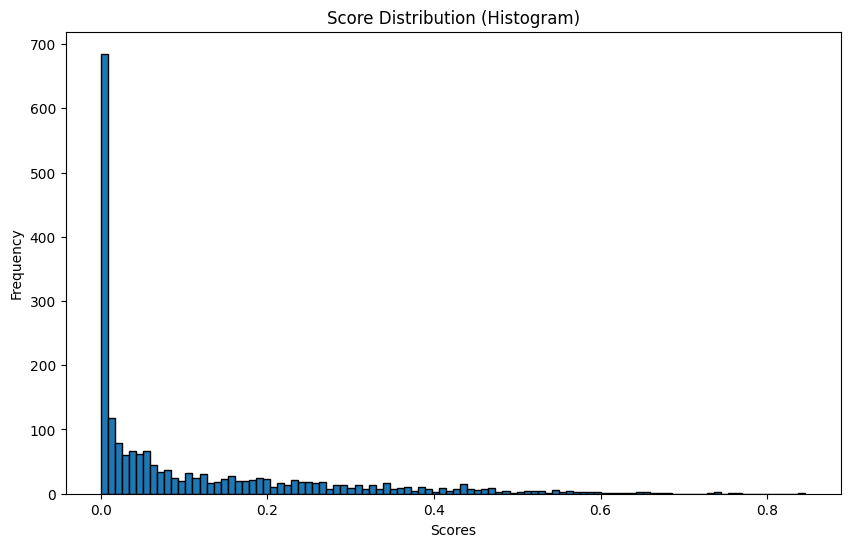

In [88]:
# ヒストグラムの描画
plt.figure(figsize=(10, 6))
plt.hist(list_geobleu_val, bins=100, edgecolor="black")
plt.title("Score Distribution (Histogram)")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.show()

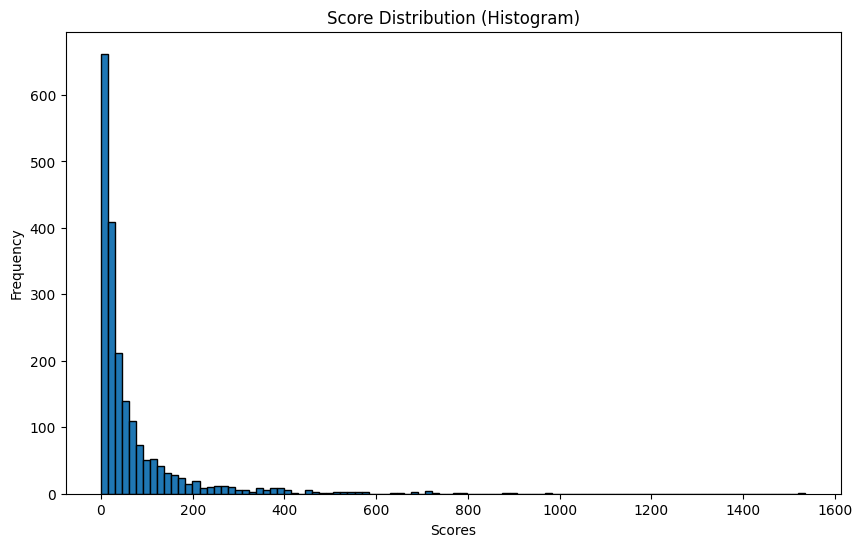

In [89]:
# ヒストグラムの描画
plt.figure(figsize=(10, 6))
plt.hist(list_dtw_val, bins=100, edgecolor="black")
plt.title("Score Distribution (Histogram)")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.show()

In [65]:
# CSV.GZファイルを読み込む
df_b = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/cityB_challengedata.csv.gz")

# データフレームの内容を表示
display(df_b.head(1))
print(len(df_b))

uid,d,t,x,y
i64,i64,i64,i64,i64
0,0,20,80,99


24375898


In [66]:
def plot_xy_trajectory(city_df: pl.DataFrame, selected_uids: list[int]) -> None:
    """ユーザーごとのx, yの推移を時間軸に沿って折れ線グラフで可視化

    args
        city_df: Polarsのデータフレーム
        selected_uids: 表示したいユーザーIDのリスト
    """

    # 選択されたUIDのデータをフィルタリングし、時間でソート
    dff = city_df.filter(pl.col("uid").is_in(selected_uids))
    dff = dff.with_columns((pl.col("d") * 48 + pl.col("t")).alias("time"))
    dff = dff.sort("time")

    # Pandasデータフレームに変換
    dff_pd = dff.to_pandas()

    # X座標の推移を描画
    x_line_fig = px.line(
        dff_pd,
        x="time",
        y="x",
        color="uid",
        labels={"x": "Time", "y": "X Position", "uid": "User ID"},
        title="User X Position Over Time",
        range_y=[0, 200],  # y座標の範囲を指定
    )
    x_line_fig.update_traces(mode="lines+markers")

    # Y座標の推移を描画
    y_line_fig = px.line(
        dff_pd,
        x="time",
        y="y",
        color="uid",
        labels={"x": "Time", "y": "Y Position", "uid": "User ID"},
        title="User Y Position Over Time",
        range_y=[0, 200],  # y座標の範囲を指定
    )
    y_line_fig.update_traces(mode="lines+markers")

    # グラフの表示
    x_line_fig.show()
    y_line_fig.show()

In [67]:
def plot_xy_trajectory_submit(subs: dict, selected_uid: int) -> None:

    # submitファイル用にuidを再定義
    new_uid = selected_uid - 20000

    # 選択されたUIDの部分を抽出
    _pred_dict = subs["generated"][new_uid]
    # 辞書に変換したのちにpolarsに変換
    _pred_dict = [{"d": item[0], "t": item[1], "x": item[2], "y": item[3]} for item in _pred_dict]
    pred_pl = pl.DataFrame(_pred_dict)
    # time項目を追加
    pred_pl = pred_pl.with_columns((pl.col("d") * 48 + pl.col("t")).alias("time"))
    pred_pl = pred_pl.sort("time")
    pred_pl = pred_pl.with_columns(pl.lit("Prediction").alias("type"))

    # Pandasデータフレームに変換
    pred_pd = pred_pl.to_pandas()

    # 選択されたUIDの部分を抽出
    _act_dict = subs["reference"][new_uid]
    # 辞書に変換したのちにpolarsに変換
    _act_dict = [{"d": item[0], "t": item[1], "x": item[2], "y": item[3]} for item in _act_dict]
    act_pl = pl.DataFrame(_act_dict)
    # time項目を追加
    act_pl = act_pl.with_columns((pl.col("d") * 48 + pl.col("t")).alias("time"))
    act_pl = act_pl.sort("time")
    act_pl = act_pl.with_columns(pl.lit("Actual").alias("type"))
    # Pandasデータフレームに変換
    act_pd = act_pl.to_pandas()

    # 予測値と実測値を1つのデータフレームに結合
    combined_df = pd.concat([pred_pd, act_pd])

    # X座標の推移を描画
    x_line_fig = px.line(
        combined_df,
        x="time",
        y="x",
        color="type",
        labels={"x": "Time", "y": "X Position", "type": "Data Type"},
        title="User X Position Over Time",
        range_y=[0, 200],  # y座標の範囲を指定
    )
    x_line_fig.update_traces(mode="lines+markers")
    # x_line_fig.update_layout(yaxis=dict(range=[0, 200]))  # y軸を0から200に固定

    # Y座標の推移を描画
    y_line_fig = px.line(
        combined_df,
        x="time",
        y="y",
        color="type",
        labels={"x": "Time", "y": "Y Position", "type": "Data Type"},
        title="User Y Position Over Time",
        range_y=[0, 200],  # y座標の範囲を指定
    )
    y_line_fig.update_traces(mode="lines+markers")
    # y_line_fig.update_layout(yaxis=dict(range=[0, 200]))  # y軸を0から200に固定

    # グラフの表示
    x_line_fig.show()
    y_line_fig.show()

In [90]:
list_geobleu_val

[0.6591998010662653,
 0.06361997282793494,
 0.05286268610518907,
 0.08432341455005159,
 0.397640820805466,
 0.010205880906612508,
 0.037990102865430225,
 0.0006057188105099017,
 0.04667618085052088,
 0.05898004585924524,
 6.703639068882797e-15,
 0.4195132538884809,
 0.033448606641806176,
 0.0015525233355100263,
 0.218343996044472,
 0.05426475210805273,
 0.05991505755661084,
 0.023952593458009673,
 0.04747454274496068,
 0.08540729977030266,
 3.7609886459925048e-06,
 0.18942928157586914,
 0.5608708635120607,
 0.05502944563707938,
 0.04319853712939656,
 0.001134071447836881,
 0.0034633805891410995,
 1.1831228953711969e-05,
 1.4960081110985291e-07,
 0.07411269781285242,
 1.4417183629390913e-25,
 1.046443557979731e-05,
 5.786043985891969e-14,
 8.249598226537631e-05,
 0.24980424166825815,
 0.09126900491886353,
 0.6170437895629651,
 0.05351681201146424,
 0.010110014416432061,
 0.0003370708283923126,
 0.06376069968329884,
 0.06779958370689178,
 0.6006922909394334,
 7.790572111566748e-06,
 0.00

In [94]:
test_case = 20001

In [95]:
plot_xy_trajectory(df_b, test_case)

In [96]:
plot_xy_trajectory_submit(subsB, test_case)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

